In [1]:
% matplotlib inline
import re
import importlib
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
from spiker import *
from IPython.display import clear_output, Image, display, HTML

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"


In [2]:
# Generate simulation data
mackay_data = np.load('mackey_glass_t17.npy') #  http://minds.jacobs-university.de/mantas/code
def gen_data(nblocks,f1,f2,tseries,amp=1e-9):
    time = tseries.time
    Ts = tseries.Ts
    ip = np.array([])
    op = np.array([])
    tblockend = int(len(time)/nblocks)
    timeblock = time[:tblockend]
    for index in range(nblocks):
        if np.random.randint(2):
            block = 2*np.sin(2*np.pi*timeblock*f2)+np.sin(2*np.pi*timeblock*f1)+2
            ip = np.concatenate((ip,block))
            op = np.concatenate((op,np.ones_like(timeblock)))
        else:
            block = 0.3*np.sin(2*np.pi*timeblock*f2)+np.sin(2*np.pi*timeblock*f2)**2+1
            ip = np.concatenate((ip,block))
            op = np.concatenate((op,np.zeros_like(timeblock)))
    return amp*ip, amp*op

In [3]:
# Simulation setting parameters
Ts = 1e-6
tstart = 0
tstop = 2
tseries = gen_time(tstart,tstop,Ts)
time = tseries.time

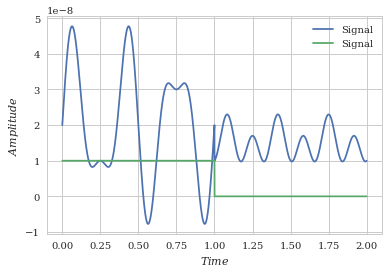

In [4]:
# Test data generation
nblocks = 2
f1 = 5
f2 = 3
amp = 10e-9
test_ip, test_op = gen_data(nblocks,f1,f2,tseries,amp)
ip = Tseries(test_ip,time,Ts)
op = Tseries(test_op,time,Ts)

test_ip = np.vstack((amp*np.zeros_like(tseries.time),test_ip)) # adding bias
ip.plot()
op.plot()

Total nodes # =  25
Input nodes # =  2
Input neuron # =  2
Reservoir neuron # =  20
Output neuron # =  1


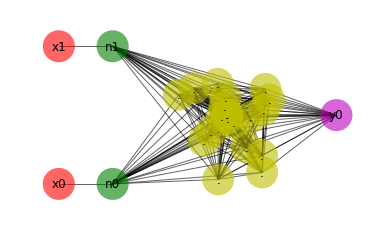

In [26]:
# generate the network
inSize = 1
outSize = 1
resSize = 20
Win = (np.random.rand(resSize,1+inSize)-0.5) * 1
W = np.random.rand(resSize,resSize)-0.5
# compute the spectral radius of these weights:
radius = np.max(np.abs(np.linalg.eigvals(W)))
# rescale them to reach the requested spectral radius:
W = W * (1.0 / radius)

Wout = np.random.rand(outSize,1+inSize+resSize)-0.5
G,W_full = create_graph(W,Win,Wout)
plt.tight_layout()
plt.savefig('ESNgraph.pdf')

# --------------------------------
# Standard ESN using real elements
# --------------------------------
def realesn():
    nnodes,nip,nnip,nnres,nop = compute_nodes(Win,Wout,W)    
    count = nop
    test = np.zeros((count,len(tseries.time)))
    x = np.zeros((resSize,1))
    res = np.zeros((nop,1))
    
    ndecay = tau/Ts
    d = -ndecay/np.log(np.exp(-1))
    # the retention factor inside reservoir = exp(-nsamples_in_tau/a)
    # chosen so that in time tentau, the value of exponent is 0
    a = 1 - np.exp(-1/d)

    for t in range(len(test_ip[0,:])):
        u = test_ip[:,t]
        u.shape = (len(u),1)
        data_in = np.dot( Win, u)
        data_in.shape = (resSize,1)
        x = (1-a)*x + a*np.tanh(data_in + np.dot( W, x ))
        x = np.maximum(x,0)
        res = (1-a)*res + a*np.dot( Wout, np.vstack((u,x)))
        res = np.maximum(res,0)
        test[:,t] = res[:,0]
    return test

In [27]:
Cmem  = 2e-12 # Membrane cap
Kappa = 0.7
Temp  = 300 # temperature in kelvin
Ut    = 1.38064852e-23 * Temp/1.60217662e-19 # kt/q
Itau  = 30e-12 #50e-12
Ith   = 30e-12 #5e-9
Iin   = 50e-9
gain  = Ith/Itau # DPI gain
tau   = Cmem*Ut/(Kappa * Itau)

In [28]:
# Standard ESN using real elements
# --------------------------------
def realesn():
    nnodes,nip,nnip,nnres,nop = compute_nodes(Win,Wout,W)    
    count = nop
    test = np.zeros((count,len(tseries.time)))
    x = np.zeros((resSize,1))
    res = np.zeros((nop,1))
    
    ndecay = tau/Ts
    d = -ndecay/np.log(np.exp(-1))
    # the retention factor inside reservoir = exp(-nsamples_in_tau/a)
    # chosen so that in time tentau, the value of exponent is 0
    a = 1 - np.exp(-1/d)

    for t in range(len(test_ip[0,:])):
        u = test_ip[:,t]
        u.shape = (len(u),1)
        data_in = np.dot( Win, u)
        data_in.shape = (resSize,1)
        x = (1-a)*x + a*np.tanh(data_in + np.dot( W, x ))
        x = np.maximum(x,0)
        res = (1-a)*res + a*np.dot( Wout, np.vstack((u,x)))
        res = np.maximum(res,0)
        test[:,t] = res[:,0]
    return test

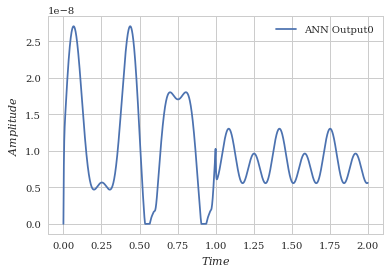

In [29]:
res = realesn()
count = outSize
for index in range(count):
    result = Tseries(res[index,:],tseries.time)
    result.plot(label = "ANN Output"+str(index))
    #plt.figure()
plt.savefig("ANN-ESN.pdf")

In [9]:
# Sigma Delta ESN - numpy
# ---------------------------------
def sdesn():
    nnodes,nip,nnip,nnres,nop = compute_nodes(Win,Wout,W)
    # X = input: dim = (nip + 1) x 1
    # N = input neurons to convert X to spikes: dim = nip x 1
    # R = reservoir neurons: dim = nres x nres
    # Y = output neurons: dim = nop x 1
    # Wab = weight matrix such that B = W.A
    # Xip = input to the layer X
    # Xop = output from layer X

    X = test_ip
    N = Neuron(nnip,
             ipItau  = 50e-12,
             ipIth   = 50e-12,
             fbItau  = 10e-12,
             fbIth   = 300e-12,
             fbIin   = 40e-9,
             eItau   = 10e-12,
             eIth    = 50e-9,
             Ts=Ts)
    R = Neuron(nnres,
             ipItau  = 50e-12,
             ipIth   = 50e-12,
             fbItau  = 10e-12,
             fbIth   = 300e-12,
             fbIin   = 40e-9,
             eItau   = 10e-12,
             eIth    = 50e-9,
             Ts=Ts)
    Y = Neuron(nop,
             ipItau  = 50e-12,
             ipIth   = 50e-12,
             fbItau  = 10e-12,
             fbIth   = 300e-12,
             fbIin   = 40e-9,
             eItau   = 10e-12,
             eIth    = 50e-9,
             Ts=Ts)
    O = Vsyn(nop,
             Itau  = 30e-12,
             Ith   = 30e-12,
             Ts=Ts)    # Readout to LPF neuron output

    Wxn = np.eye(nip)
    Wnr = Win
    Wrr = W
    Wry = Wout
    Wyo = np.eye(nop)
    
    Rop = np.zeros(nnres)
    
    count = nop
    esn = np.zeros((count,len(tseries.time)))
    for index in range(len(tseries.time)):
        ip = X[:,index]
    
        Nip = np.dot(Wxn,ip)
        Nop = N.compute(Nip)
        
        Rip = np.dot(Wnr,Nop) + np.dot(Wrr,Rop)
        Rop = R.compute(Rip)
        
        Yip = np.dot(Wry,np.hstack((ip,Rop)))
        Yop = Y.compute(Yip)
        
        O.compute(Yop)
        esn[:,index] = O.states
    return esn,count

In [31]:
esn,count = sdesn()

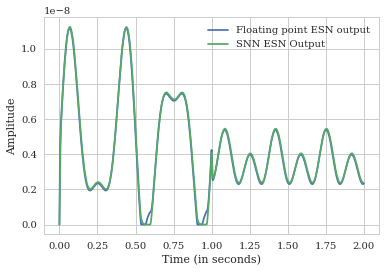

In [32]:
# we'll disregard the first few states:
transient = 100
# include the raw inputs:
# extended_states = np.concatenate((res, test_ip),axis=0)
# Solve for W_out:
W_out = np.dot(test_op[transient:], np.linalg.pinv(res[:, transient:]))
op = np.dot(W_out, res)
plt.plot(tseries.time, op, label = 'Floating point ESN output')

op = np.dot(W_out, esn)
plt.plot(tseries.time, op, label = 'SNN ESN Output', alpha=0.7)
plt.ylabel('Amplitude')
plt.xlabel('Time (in seconds)')
plt.legend()
plt.savefig("ANN-SDNN.pdf", dpi=300)

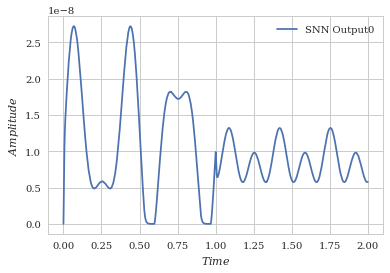

In [33]:
for index in range(count):
    esnres = Tseries(esn[index,:],tseries.time)
    esnres.plot(0, label = "SNN Output"+str(index))
plt.savefig("SDNN-ESN.pdf")